In [1]:
from incense import ExperimentLoader
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [84]:
E = ExperimentLoader(mongo_uri='mongodb://localhost', db_name='chai')

In [85]:
exps = E.find_all()
exps = list(filter(lambda e: e.to_dict()['status'] == 'COMPLETED', exps))
exps = list(filter(lambda e: e.to_dict()['config']['_call']['name'] == 'adversarial_speed', exps))

(array([240.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 240.]),
 array([18513.67183706, 18520.30218469, 18526.93253232, 18533.56287995,
        18540.19322758, 18546.82357521, 18553.45392284, 18560.08427047,
        18566.7146181 , 18573.34496573, 18579.97531336]),
 <BarContainer object of 10 artists>)

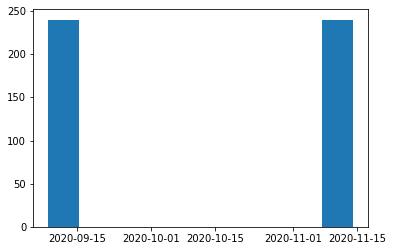

In [86]:
plt.hist([e.to_dict()['stop_time'] for e in exps])

In [87]:
exps = list(filter(lambda e: e.to_dict()['stop_time'].month >= 10, exps))

(array([23., 22., 28., 30., 25., 27., 25., 19., 20., 21.]),
 array([18579.27819419, 18579.34790611, 18579.41761802, 18579.48732994,
        18579.55704186, 18579.62675377, 18579.69646569, 18579.76617761,
        18579.83588952, 18579.90560144, 18579.97531336]),
 <BarContainer object of 10 artists>)

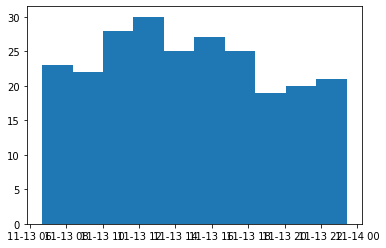

In [88]:
plt.hist([e.to_dict()['stop_time'] for e in exps])

In [89]:
len(exps)

240

In [90]:
def exp_data(exp):
    exp_data = {'time_sacred': (exp.to_dict()['stop_time'] - exp.to_dict()['start_time']).total_seconds(),
                'time_tune': exp.metrics['time_total_s'].iloc[-1],
                'num_workers': exp.to_dict()['config']['num_workers'],
                'train_batch_size': exp.to_dict()['config']['train_batch_size'],
                'episode_len_mean': np.mean(exp.metrics['episode_len_mean']),
                'timesteps_total': exp.metrics['timesteps_total'].iloc[-1],
                'sample_time_ms': np.mean(exp.metrics['timers/sample_time_ms']),
                'num_envs_per_worker': exp.to_dict()['config']['num_envs_per_worker'],
                'sample_throughput': np.mean(exp.metrics['timers/sample_throughput'])}
    return exp_data

In [91]:
exps = [exp_data(exp) for exp in exps]

In [92]:
df = pd.DataFrame(exps)
df.columns

Index(['time_sacred', 'time_tune', 'num_workers', 'train_batch_size',
       'episode_len_mean', 'timesteps_total', 'sample_time_ms',
       'num_envs_per_worker', 'sample_throughput'],
      dtype='object')

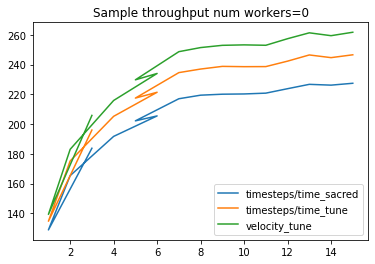

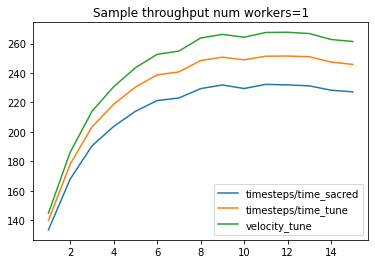

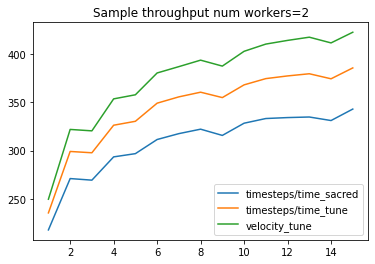

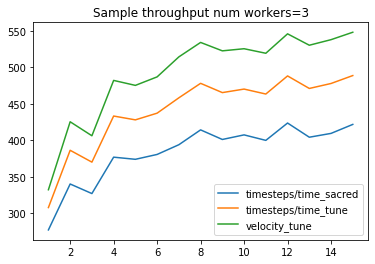

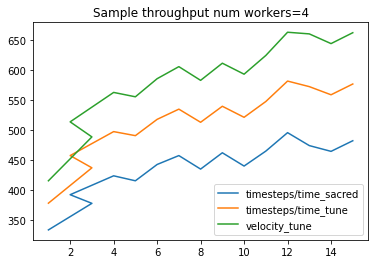

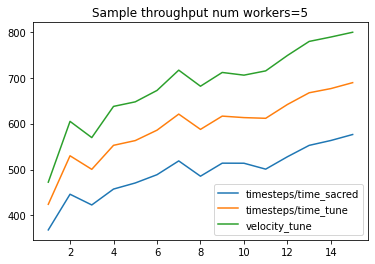

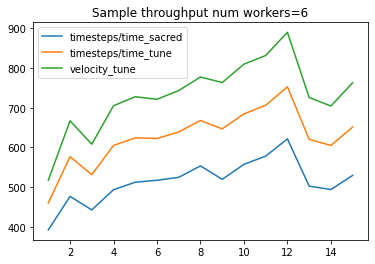

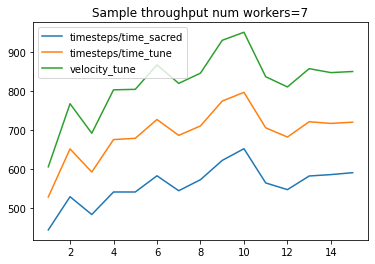

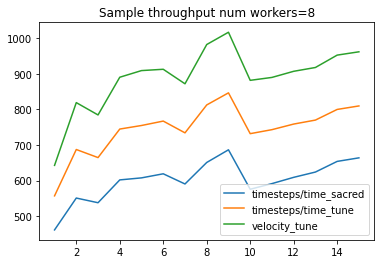

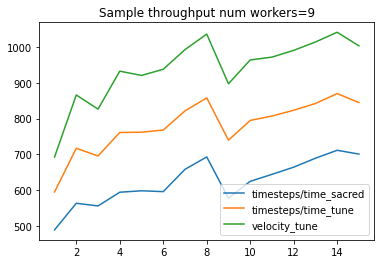

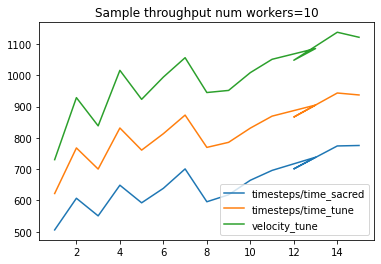

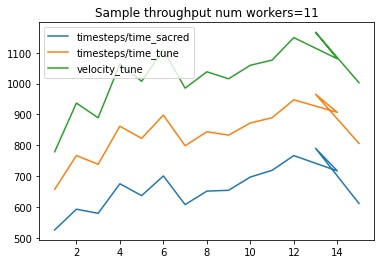

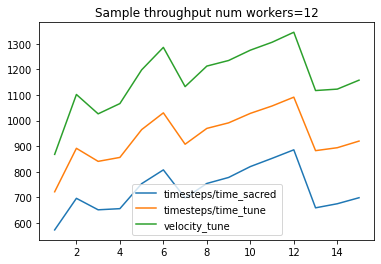

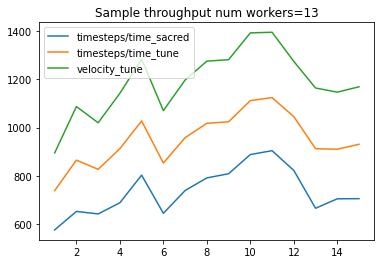

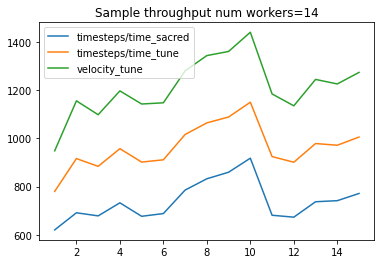

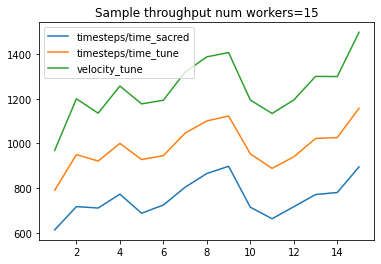

In [93]:
for w, df_ in df.groupby('num_workers'):
    plt.figure()
    plt.title(f"Sample throughput num workers={w}")
    plt.plot(df_['num_envs_per_worker'], df_['timesteps_total'] / df_['time_sacred'], label=f"timesteps/time_sacred")
    plt.plot(df_['num_envs_per_worker'], df_['timesteps_total'] / df_['time_tune'], label=f"timesteps/time_tune")
    plt.plot(df_['num_envs_per_worker'], df_['sample_throughput'], label=f"velocity_tune")
    
    plt.legend()
    plt.show()

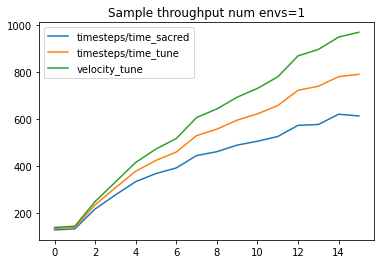

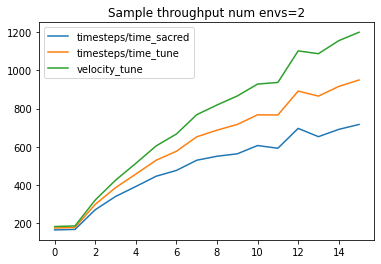

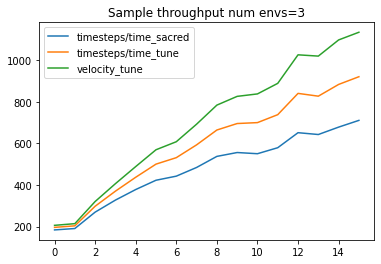

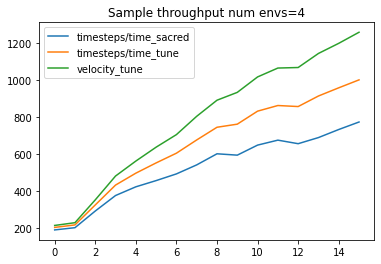

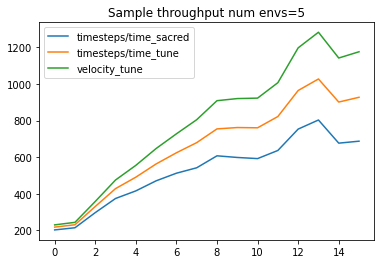

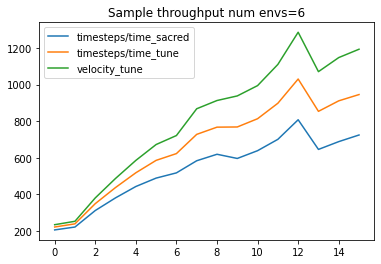

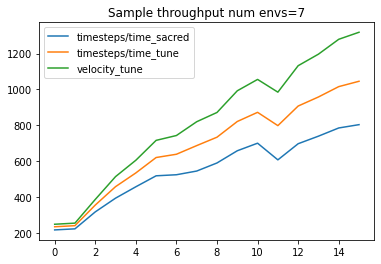

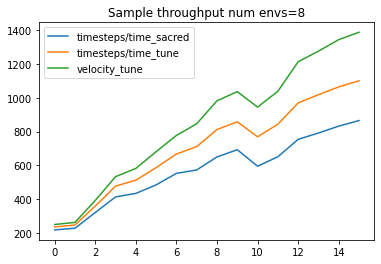

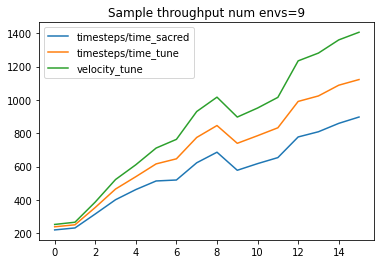

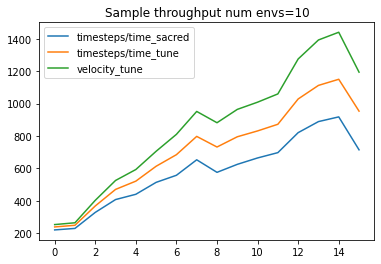

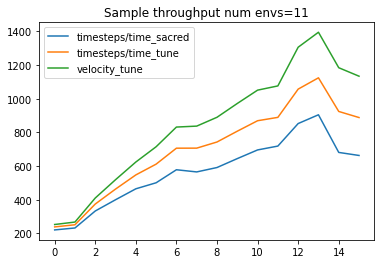

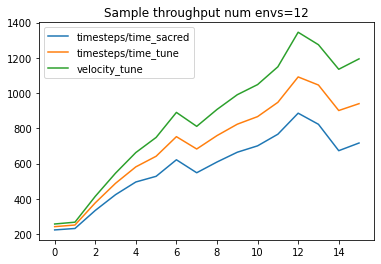

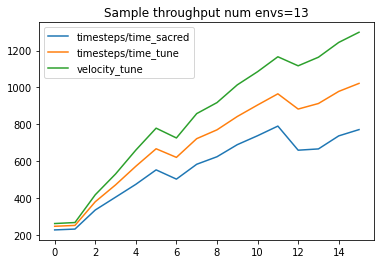

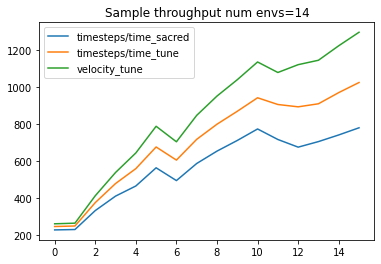

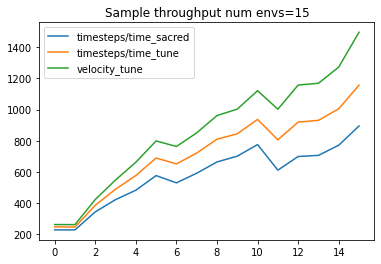

In [94]:
for e, df_ in df.groupby('num_envs_per_worker'):
    plt.figure()
    plt.title(f"Sample throughput num envs={e}")
    plt.plot(df_['num_workers'], df_['timesteps_total'] / df_['time_sacred'], label=f"timesteps/time_sacred")
    plt.plot(df_['num_workers'], df_['timesteps_total'] / df_['time_tune'], label=f"timesteps/time_tune")
    plt.plot(df_['num_workers'], df_['sample_throughput'], label=f"velocity_tune")
    
    plt.legend()
    plt.show()

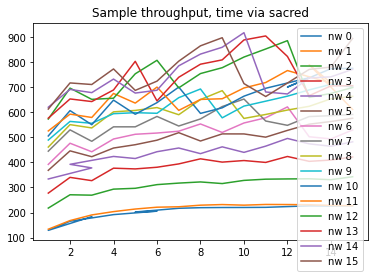

In [95]:
plt.figure()
plt.title(f"Sample throughput, time via sacred")

for w, df_ in df.groupby('num_workers'):
    
    plt.plot(df_['num_envs_per_worker'], df_['timesteps_total'] / df_['time_sacred'], label=f"nw {w}")
    
plt.legend()
plt.show()

In [106]:
# df['rate'] = df['timesteps_total'] / df['time_sacred']
df['rate'] = df['sample_throughput']

/scratch/sergei/miniconda3/envs/adv-tf2/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='time_sacred', ylabel='timesteps_total'>

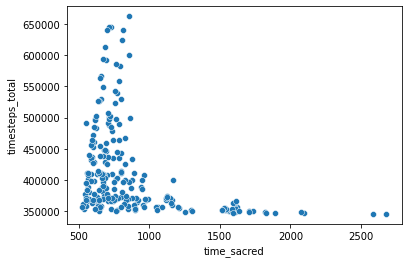

In [107]:
sns.scatterplot(df['time_sacred'], df['timesteps_total'])

/scratch/sergei/miniconda3/envs/adv-tf2/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='rate', ylabel='timesteps_total'>

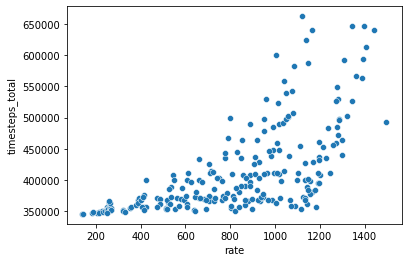

In [108]:
sns.scatterplot(df['rate'], df['timesteps_total'])

In [109]:
df.rate[df.timesteps_total > 400e3] = 0

<ipython-input-109-91251bf4b5a4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rate[df.timesteps_total > 400e3] = 0


In [110]:
df_pivot = pd.pivot_table(df, values='rate', index=['num_workers'],
                columns=['num_envs_per_worker'], aggfunc=np.mean)

<AxesSubplot:xlabel='num_envs_per_worker', ylabel='num_workers'>

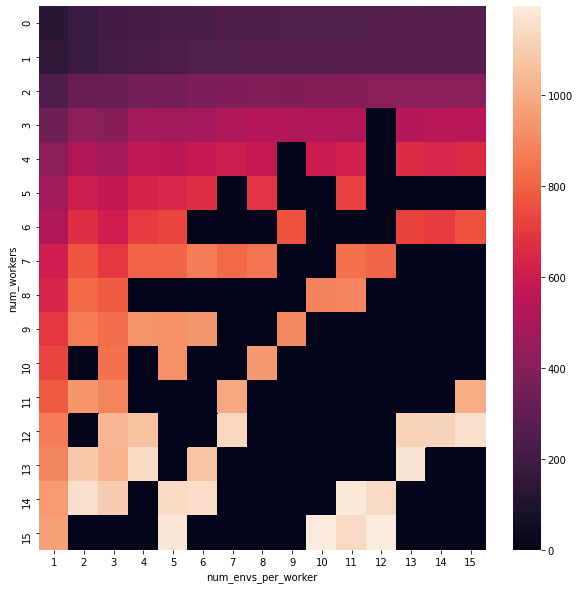

In [111]:
plt.figure(figsize=(10, 10))
sns.heatmap(df_pivot)

<AxesSubplot:xlabel='num_envs_per_worker', ylabel='num_workers'>

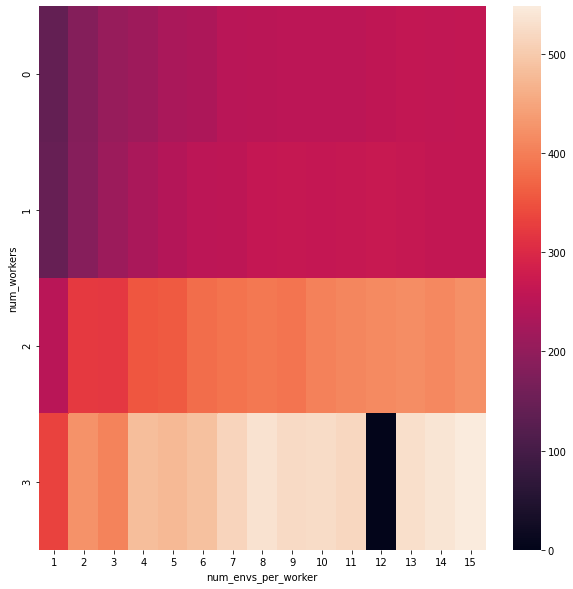

In [112]:
plt.figure(figsize=(10, 10))
sns.heatmap(df_pivot[:4])

In [103]:
df['timesteps_total'] / 11

0      31560.818182
1      31404.727273
2      31517.000000
3      31656.545455
4      31887.818182
           ...     
235    33390.909091
236    35962.727273
237    39958.636364
238    42172.454545
239    44736.000000
Name: timesteps_total, Length: 240, dtype: float64

In [104]:
exp.metrics['info/num_steps_trained']

NameError: name 'exp' is not defined